## 💸 **Compensation & Participation Signals**

*Measures wage pressure, real earnings growth, work intensity, and participation in the labor market*
**Frequency:** Monthly

| Indicator                                | Source                    | Notes                                          |
| ---------------------------------------- | ------------------------- | ---------------------------------------------- |
| Avg Weekly Earnings – Total Private      | CES (`CES0500000030`)     | Nominal earnings across majority of workforce  |
| Median Hourly Wage Growth – 3MMA         | ATL Fed (`FRBATLWGT3MMAUMHWGO`) | Smoothed median wage change, outlier-resistant |
| Prime-Age Employment-to-Population Ratio | BLS (`LNS12300060`)       | Core employment engagement (ages 25–54)        |
| Prime-Age Labor Force Participation Rate | BLS (`LNS11300060`)       | Best signal of labor force engagement          |
| Avg Weekly Hours – Total Private         | CES (`AWHAETP`)           | Reflects changes in workload and hiring demand |

---

In [8]:
import pandas as pd
import sqlite3

# Load CSV files into DataFrames
Average_Weekly_Earnings_df = pd.read_csv('Average_Weekly_Earnings.csv')
Average_Weekly_Hours_df = pd.read_csv('Average_Weekly_Hours.csv')
Median_Hourly_Wage_Growth_3MMA_df = pd.read_csv('Median_Hourly_Wage_Growth_3MMA.csv')
Prime_Employment_to_Population_Ratio_df = pd.read_csv('Prime_Employment_to_Population_Ratio.csv')
Prime_Labor_Force_Participation_Rate_df = pd.read_csv('Prime_Labor_Force_Participation_Rate.csv')
CPI_df = pd.read_csv('CPI.csv')

# Create an SQLite in-memory database
conn = sqlite3.connect(':memory:')

# Load DataFrames into the database as tables
Average_Weekly_Earnings_df.to_sql('Earnings', conn, index=False, if_exists='replace')
Average_Weekly_Hours_df.to_sql('Hours', conn, index=False, if_exists='replace')
Median_Hourly_Wage_Growth_3MMA_df.to_sql('Median_Wage_Growth_3MMA', conn, index=False, if_exists='replace')
Prime_Employment_to_Population_Ratio_df.to_sql('Prime_Employment_to_Population_Ratio', conn, index=False, if_exists='replace')
Prime_Labor_Force_Participation_Rate_df.to_sql('Prime_Labor_Force_Participation_Rate', conn, index=False, if_exists='replace')
CPI_df.to_sql('CPI', conn, index=False, if_exists='replace')



# SQL query to merge all tables on 'Player'
sql_query = """
SELECT 
    Hours.observation_date, 
    CES0500000030 as "Avg_Weekly_Earnings",
    AWHAETP as "Avg_Weekly_Hours",
    FRBATLWGT3MMAUMHWGO as "Median_Wage_Growth_3MMA",
    LNS12300060 as "Prime_Employment_to_Population_Ratio",
    LNS11300060 as "Prime_LFPR",
    CPI as "CPI"
FROM Hours
INNER JOIN Earnings ON Hours.observation_date = Earnings.observation_date
INNER JOIN Median_Wage_Growth_3MMA ON Hours.observation_date = Median_Wage_Growth_3MMA.observation_date
INNER JOIN Prime_Employment_to_Population_Ratio ON Hours.observation_date = Prime_Employment_to_Population_Ratio.observation_date
INNER JOIN Prime_Labor_Force_Participation_Rate ON Hours.observation_date = Prime_Labor_Force_Participation_Rate.observation_date
INNER JOIN CPI ON Hours.observation_date = CPI.observation_date
"""


# Execute the query and load results into a DataFrame
Labor_Compensation_Pressure_df = pd.read_sql_query(sql_query, conn)

# Save the merged DataFrame to a new CSV file
# csv_filename = "Stats/All_Player_Numbers.csv"
# Player_Numbers_df.to_csv(csv_filename, index=False)

# Close the connection
conn.close()

# Provide the file to the user


Labor_Compensation_Pressure_df

,observation_date,Avg_Weekly_Earnings,Avg_Weekly_Hours,Median_Wage_Growth_3MMA,Prime_Employment_to_Population_Ratio,Prime_LFPR,CPI
0,2006-03-01,559.05,34.2,3.8,79.8,83.0,199.700
1,2006-04-01,563.76,34.3,3.8,79.6,82.8,200.700
2,2006-05-01,561.44,34.3,3.9,79.7,82.8,201.300
3,2006-06-01,566.81,34.4,3.8,79.8,82.8,201.800
4,2006-07-01,568.84,34.3,3.7,79.8,83.0,202.900
...,...,...,...,...,...,...,...
225,2024-12-01,1033.58,34.2,4.2,80.5,83.4,317.603
226,2025-01-01,1034.88,34.1,4.1,80.7,83.5,319.086
227,2025-02-01,1038.58,34.2,4.3,80.5,83.5,319.775
228,2025-03-01,1046.45,34.3,4.3,80.4,83.3,319.615


### 🧠 **Feature Engineering:**

* `AvgWeeklyEarning_YoY = YoY % change in Avg Weekly Earnings`
  *Captures nominal wage growth*
* `RealWageGrowth = AvgWeeklyEarning_YoY – CPI_YoY`
  *Measures purchasing power of wages*
* `MedianWage3MMA_Z = z-score(Median Wage 3MMA)`
  *Standardized short-term wage signal*
* `PrimeEPOP_Z = z-score(Prime-Age Employment-to-Population)`
  *Normalized employment engagement*
* `PrimeLFPR_Trend = Current LFPR – LFPR 12 months ago`
  *Longitudinal participation shift*
* `WeeklyHours_Trend = Change in Avg Weekly Hours over 12 months`
  *Captures work intensity trends*

In [15]:
from scipy.stats import zscore

Labor_Compensation_Pressure_df['Avg_Weekly_Earning_YoY'] = Labor_Compensation_Pressure_df['Avg_Weekly_Earnings'] / Labor_Compensation_Pressure_df['Avg_Weekly_Earnings'].shift(12) - 1

Labor_Compensation_Pressure_df['RealWageGrowth'] = (Labor_Compensation_Pressure_df['Avg_Weekly_Earning_YoY']) - (Labor_Compensation_Pressure_df['CPI'] / Labor_Compensation_Pressure_df['CPI'].shift(12) - 1)
Labor_Compensation_Pressure_df['MedianWage3MMA_Z'] = zscore(Labor_Compensation_Pressure_df['Median_Wage_Growth_3MMA'], nan_policy='omit')
Labor_Compensation_Pressure_df['PrimeEPOP_Z'] = zscore(Labor_Compensation_Pressure_df['Prime_Employment_to_Population_Ratio'], nan_policy='omit')
Labor_Compensation_Pressure_df['PrimeLFPR_Trend'] =      Labor_Compensation_Pressure_df['Prime_LFPR'] - Labor_Compensation_Pressure_df['Prime_LFPR'].shift(12)
Labor_Compensation_Pressure_df['WeeklyHours_Trend'] = Labor_Compensation_Pressure_df['Avg_Weekly_Hours'] - Labor_Compensation_Pressure_df['Avg_Weekly_Hours'].shift(12)

Labor_Compensation_Pressure_df.columns


Index(['observation_date', 'Avg_Weekly_Earnings', 'Avg_Weekly_Hours',
       'Median_Wage_Growth_3MMA', 'Prime_Employment_to_Population_Ratio',
       'Prime_LFPR', 'CPI', 'Avg_Weekly_Earning_YoY', 'RealWageGrowth',
       'MedianWage3MMA_Z', 'PrimeEPOP_Z', 'PrimeLFPR_Trend',
       'WeeklyHours_Trend'],
      dtype='object')

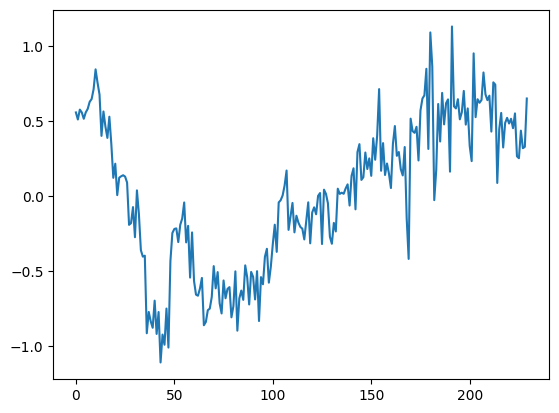

In [20]:
from scipy.stats import zscore

Labor_Compensation_Pressure_df['RealWageGrowth_Z'] = zscore(Labor_Compensation_Pressure_df['RealWageGrowth'], nan_policy='omit')
Labor_Compensation_Pressure_df['AvgWeeklyEarning_YoY_Z'] = zscore(Labor_Compensation_Pressure_df['Avg_Weekly_Earning_YoY'], nan_policy='omit')
Labor_Compensation_Pressure_df['PrimeLFPR_Trend_Z'] = zscore(Labor_Compensation_Pressure_df['PrimeLFPR_Trend'], nan_policy='omit')
Labor_Compensation_Pressure_df['WeeklyHours_Trend_Z'] = zscore(Labor_Compensation_Pressure_df['WeeklyHours_Trend'], nan_policy='omit')

Labor_Compensation_Pressure_df['Labor_Compensation_Pressure_Index'] = Labor_Compensation_Pressure_df[[
    'AvgWeeklyEarning_YoY_Z',
    'RealWageGrowth_Z',
    'MedianWage3MMA_Z',
    'PrimeEPOP_Z',
    'PrimeLFPR_Trend_Z',
    'WeeklyHours_Trend_Z'
]].mean(axis=1, skipna=True)

Labor_Compensation_Pressure_df['Labor_Compensation_Pressure_Index'].plot()


import os

os.makedirs('LCP', exist_ok=True)  # This creates the folder if it doesn't already exist

Labor_Compensation_Pressure_df[['observation_date', 'Labor_Compensation_Pressure_Index']].to_csv(
    'LCP/Labor_Compensation_Pressure_Index.csv', index=False
)

